# NFL Play Prediction: Final Model(s)

Adding more data with same architectures from last experiment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k
from tensorflow.keras.callbacks import Callback

## Load Data

Data via nflfastR. Variable selection, engineering & encoding are done in associated R script.

In [3]:
# filepath = "data"
filepath = "/content/drive/MyDrive/MSDS458_AI_and_DL/Assignment-4/data"

In [4]:
df_train_full = pd.read_csv(f'{filepath}/nfl_plays_train_update.csv')
df_valid_full = pd.read_csv(f'{filepath}/nfl_plays_valid_update.csv')
df_test_full = pd.read_csv(f'{filepath}/nfl_plays_test_update.csv')

## Helper Functions for Data Prep

remove yac with addition of yards_gained

In [5]:
def prepPlays(df, include_totals = False, include_wp = True, include_ep = True, include_epa_detail = False):
    # dropping columns that are not needed
    df = df.drop(['season', 'week', 'drive','series', 'surface', 'season_type', 'home_team','away_team', 'spread_line',
                   'game_date','play_id', 'desc','two_point_attempt', 'posteam_type','defteam', 'game_half', 'passer_name', 'passer_player_id',
                     'quarter_end', 'pass_attempt','rush_attempt','field_goal_attempt', 'punt_attempt', 'half_seconds_remaining', 'drive_play_count', 'pass_deep', 'pass_right', 'pass_left', 'yards_after_catch',
                  'pt_run_left_pct', 'pt_run_right_pct', 'pt_rush_wpa_play', 'pt_pass_wpa_play', 'dt_fd_pass_pct',
       'dt_sd_pass_pct', 'dt_td_pass_pct', 'dt_gtg_pass_pct',
       'dt_neutral_pass_pct', 'dt_scripted_pass_pct', 'dt_pass_pct',
       'dt_run_left_pct', 'dt_run_right_pct', 'dt_rush_wpa_play', 'dt_pass_wpa_play',
       'pt_sd_pass_pct', 'pt_td_pass_pct', 'pt_gtg_pass_pct', 'qb_dropback', 'qb_spike', 'qb_scramble', 'no_huddle', 'shotgun',
                  ], axis = 1)

    if include_totals == False:
        df = df.drop(['total_away_rush_epa', 'total_home_rush_epa', 'total_away_pass_epa', 'total_home_pass_epa', 'total_away_rush_wpa', 'total_home_rush_wpa', 'total_away_pass_wpa', 'total_home_pass_wpa'], axis=1)
    
    if include_wp == False:
        df = df.drop(['wp'], axis=1)

    if include_ep == False:
        df = df.drop(['ep'], axis=1)
    
    if include_epa_detail == False:
        df = df.drop(['air_epa', 'yac_epa'], axis=1)

    df['drive_time_of_possession'] = df['drive_time_of_possession'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
    df['roof'] = df['roof'].apply(lambda x: 'closed' if x == 'dome' else 'open' if x == 'outdoors' else x)
    df['roof'] = df['roof'].apply(lambda x: 1 if x == 'closed' else 0)
    
    # df['game_id_posteam'] = df['game_id'] + df['posteam']
    # df = df.drop(['game_id', 'posteam'], axis=1, inplace=True)

    # sorting the dataframe by game_id, posteam, and play number
    df = df.sort_values(by=['game_id', 'posteam', 'pt_play_no'])

    return df

def encodePlayType(df, play_types):
    n_play_types = len(play_types)
    df['play_type_encoded'] = df['play_type'].apply(lambda x: play_types.index(x))

    return df

## Helper Functions for Modeling/Post processing

In [6]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

class TimeCallback(Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()

    def on_train_end(self, logs=None):
        self.train_end_time = time.time()
        print(f"Training time: {self.train_end_time - self.train_start_time} seconds")

## Prep Plays Datasets

In [7]:
df_train = prepPlays(df_train_full[df_train_full['season'] >= 2020])
df_valid = prepPlays(df_valid_full[df_valid_full['season'] >= 2020])
df_test = prepPlays(df_test_full[df_test_full['season'] == 2022])

check for remaining categorical columns to encode

In [8]:
print("number of categorical columns: ", len(df_train.select_dtypes(include=['object']).columns))
print("number of numeric columns: ", len(df_train.select_dtypes(include=['int64','float64']).columns))
print("number of total columns: ", len(df_train.select_dtypes(include=['object']).columns) +  len(df_train.select_dtypes(include=['int64','float64']).columns))
print("categorical columns ",df_train.select_dtypes(include=['object']).columns.values)

number of categorical columns:  3
number of numeric columns:  46
number of total columns:  49
categorical columns  ['game_id' 'play_type' 'posteam']


In [9]:
df_train.select_dtypes(include  =['int64', 'int32', 'float32', 'float64']).columns

Index(['total_line', 'drive_time_of_possession', 'yardline_100',
       'quarter_seconds_remaining', 'game_seconds_remaining', 'qtr',
       'drive_start', 'down', 'goal_to_go', 'ydstogo',
       'home_timeouts_remaining', 'away_timeouts_remaining',
       'score_differential', 'qb_epa', 'roof', 'temp', 'wind', 'penalty',
       'penalty_yards', 'timeout', 'qb_hit', 'air_yards', 'first_down',
       'yards_gained', 'epa', 'wpa', 'wp', 'ep', 'pt_play_no', 'pt_spread',
       'pt_fd_pass_pct', 'pt_neutral_pass_pct', 'pt_scripted_pass_pct',
       'pt_pass_pct', 'pt_rush_epa_play', 'pt_pass_epa_play',
       'dt_rush_epa_play', 'dt_pass_epa_play', 'pos_team_game_no',
       'def_team_game_no', 'qb_pass_attempts', 'qb_pass_epa_play_adj',
       'qb_pass_wpa_play_adj', 'pt_penalty', 'pt_timeout', 'pt_home'],
      dtype='object')

## Encode target variables

In [10]:
df_train['run_direction'] = df_train['play_type'].map({'run_left':'left', 'run_right':'right', 'run_middle':'middle'})
df_train['play_type'] = df_train['play_type'].map({'run_left':'run', 'run_right':'run', 'run_middle':'run', 'pass':'pass', 'field_goal':'fg', 'punt':'punt'})

df_valid['run_direction'] = df_valid['play_type'].map({'run_left':'left', 'run_right':'right', 'run_middle':'middle'})
df_valid['play_type'] = df_valid['play_type'].map({'run_left':'run', 'run_right':'run', 'run_middle':'run', 'pass':'pass', 'field_goal':'fg', 'punt':'punt'})

df_test['run_direction'] = df_test['play_type'].map({'run_left':'left', 'run_right':'right', 'run_middle':'middle'})
df_test['play_type'] = df_test['play_type'].map({'run_left':'run', 'run_right':'run', 'run_middle':'run', 'pass':'pass', 'field_goal':'fg', 'punt':'punt'})

In [11]:
label_encoder = LabelEncoder()

df_train['play_type_encoded'] = label_encoder.fit_transform(df_train['play_type'])
df_valid['play_type_encoded'] = label_encoder.fit_transform(df_valid['play_type'])
df_test['play_type_encoded'] = label_encoder.fit_transform(df_test['play_type'])

In [12]:
label_encoder2 = LabelEncoder()

df_train['run_direction_encoded'] = label_encoder2.fit_transform(df_train['run_direction'])
df_valid['run_direction_encoded'] = label_encoder2.fit_transform(df_valid['run_direction'])
df_test['run_direction_encoded'] = label_encoder2.fit_transform(df_test['run_direction'])

Check class balance

In [13]:
print(df_train.groupby(['play_type_encoded', 'play_type']).size())
print(df_valid.groupby(['play_type_encoded', 'play_type']).size())
print(df_test.groupby(['play_type_encoded', 'play_type']).size())

play_type_encoded  play_type
0                  fg            1487
1                  pass         30297
2                  punt          2931
3                  run          19159
dtype: int64
play_type_encoded  play_type
0                  fg             500
1                  pass         10436
2                  punt          1048
3                  run           6538
dtype: int64
play_type_encoded  play_type
0                  fg            1062
1                  pass         20210
2                  punt          2200
3                  run          13442
dtype: int64


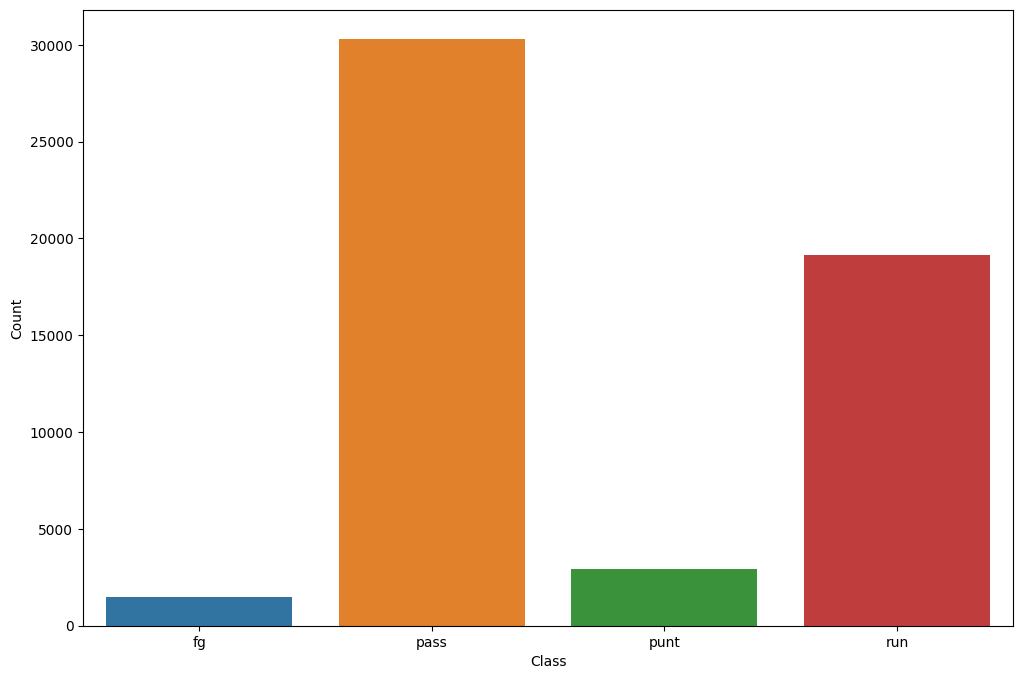

In [14]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(df_train['play_type']).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [15]:
print(df_train.groupby(['run_direction_encoded', 'play_type']).size())
print(df_valid.groupby(['run_direction_encoded', 'play_type']).size())
print(df_test.groupby(['run_direction_encoded', 'play_type']).size())

run_direction_encoded  play_type
0                      run           7010
1                      run           5179
2                      run           6970
3                      fg            1487
                       pass         30297
                       punt          2931
dtype: int64
run_direction_encoded  play_type
0                      run           2425
1                      run           1737
2                      run           2376
3                      fg             500
                       pass         10436
                       punt          1048
dtype: int64
run_direction_encoded  play_type
0                      run           5140
1                      run           3443
2                      run           4859
3                      fg            1062
                       pass         20210
                       punt          2200
dtype: int64


## Scale Numeric Columns

In [16]:
scaler = MinMaxScaler()
numeric_cols = df_train.select_dtypes(include=['int64','float64']).columns
numeric_cols = numeric_cols[numeric_cols != 'pt_play_no']
numeric_cols = numeric_cols[numeric_cols != 'play_type_encoded']
numeric_cols = numeric_cols[numeric_cols != 'run_direction_encoded']

scaler.fit(df_train[numeric_cols])

df_train[numeric_cols] = scaler.transform(df_train[numeric_cols])
df_valid[numeric_cols] = scaler.transform(df_valid[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

reordering for display purposes

In [17]:
colorder = ['game_id', 'posteam', 'pt_play_no', 'play_type', 'play_type_encoded', 'run_direction', 'run_direction_encoded']
colorder = colorder + [col for col in df_train.columns if col not in colorder]
df_train = df_train[colorder]
df_valid = df_valid[colorder]
df_test = df_test[colorder]

## Slice and restructure data

Select columns and create lists grouped by posteam game. Structure is ***(posteam_games X plays_in_game X features)***

In [18]:
# convert to sequences of plays for each posteam/game
X_train = df_train.drop(['pt_play_no', 'play_type', 'play_type_encoded', 'run_direction', 'run_direction_encoded'],axis = 1).groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()
Y_train = df_train[['game_id','posteam', 'play_type_encoded']].groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()

X_valid = df_valid.drop(['pt_play_no', 'play_type', 'play_type_encoded', 'run_direction', 'run_direction_encoded'],axis = 1).groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()
Y_valid = df_valid[['game_id','posteam', 'play_type_encoded']].groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()

X_test = df_test.drop(['pt_play_no', 'play_type', 'play_type_encoded', 'run_direction', 'run_direction_encoded'],axis = 1).groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()
Y_test = df_test[['game_id','posteam', 'play_type_encoded']].groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()

In [19]:
# remove the identifier columns for each dataset
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        X_train[i][j] = X_train[i][j][2:]

for i in range(len(Y_train)):
    for j in range(len(Y_train[i])):
        Y_train[i][j] = Y_train[i][j][2:]

for i in range(len(X_valid)):
    for j in range(len(X_valid[i])):
        X_valid[i][j] = X_valid[i][j][2:]

for i in range(len(Y_valid)):
    for j in range(len(Y_valid[i])):
        Y_valid[i][j] = Y_valid[i][j][2:]

for i in range(len(X_test)):
    for j in range(len(X_test[i])):
        X_test[i][j] = X_test[i][j][2:]

for i in range(len(Y_test)):
    for j in range(len(Y_test[i])):
        Y_test[i][j] = Y_test[i][j][2:]

In [20]:
def print_dimensions(nested_list):
    if isinstance(nested_list, list):
        print("number of games: ", len(nested_list))
        play_count = 0
        play_list = []
        for i in nested_list:
            plays = len(i)
            play_count += plays
            play_list.append(plays)
        print("min number of plays per game: ", np.min(play_list))
        print("average number of plays per game: ", np.mean(play_list))
        print("maximum number of plays per game:", np.max(play_list))
        print("total number of plays: ", play_count)
        print("number of features: ", len(nested_list[0][0]))
    else:
        print()
        
print("X dims")
print_dimensions(X_train)
print("")
print("Y dims")
print_dimensions(Y_train)

X dims
number of games:  786
min number of plays per game:  45
average number of plays per game:  68.54198473282443
maximum number of plays per game: 102
total number of plays:  53874
number of features:  45

Y dims
number of games:  786
min number of plays per game:  45
average number of plays per game:  68.54198473282443
maximum number of plays per game: 102
total number of plays:  53874
number of features:  1


In [21]:
# validation
print("X dims")
print_dimensions(X_valid)
print("")
print("Y dims")
print_dimensions(Y_valid)

X dims
number of games:  270
min number of plays per game:  48
average number of plays per game:  68.6
maximum number of plays per game: 99
total number of plays:  18522
number of features:  45

Y dims
number of games:  270
min number of plays per game:  48
average number of plays per game:  68.6
maximum number of plays per game: 99
total number of plays:  18522
number of features:  1


In [22]:
# validation
print("X dims")
print_dimensions(X_test)
print("")
print("Y dims")
print_dimensions(Y_test)

X dims
number of games:  542
min number of plays per game:  44
average number of plays per game:  68.1070110701107
maximum number of plays per game: 100
total number of plays:  36914
number of features:  45

Y dims
number of games:  542
min number of plays per game:  44
average number of plays per game:  68.1070110701107
maximum number of plays per game: 100
total number of plays:  36914
number of features:  1


## Create timeseries datasets

pad sequences

In [23]:
# pad sequences to max length
def padSequence(x_sequence, y_sequence, max_length = 105):
    X_padded = []
    Y_padded = []
    for i in range(len(x_sequence)):
        padded = np.pad(x_sequence[i], ((max_length-np.array(x_sequence[i]).shape[0],0), (0,0)), 'constant')
        X_padded.append(padded)
    for i in range(len(y_sequence)):
        padded = np.pad(y_sequence[i], ((max_length-np.array(y_sequence[i]).shape[0],0), (0,0)), 'constant')
        Y_padded.append(padded)
    return np.array(X_padded), np.array(Y_padded)


max_length = 102
X_train_padded, Y_train_padded = padSequence(X_train, Y_train, max_length)
X_valid_padded, Y_valid_padded = padSequence(X_valid, Y_valid, max_length)
X_test_padded, Y_test_padded = padSequence(X_test, Y_test, max_length)

Using the timeseries_dataset_from_array utility, but want to ensure that sequences are only created within the same game, and not overlapping games. Here, we loop through the games and create windowed sequences of a specified length for each game. For each game there will be one dataset object, which we then have to concatenate using the concatenate Dataset method.

Trying to get entire game processed as one batch

In [24]:
101 - 15 + 1

87

In [25]:
sequence_length = 15
batch_size = 87
n_feats = len(X_train[0][0])
delay = sequence_length + 1 - 1
train_datasets = []
valid_datasets = []
test_datasets = []
for i in range(len(X_train)):
    dataset = tf.keras.utils.timeseries_dataset_from_array(
        X_train_padded[i][:-delay],
        targets = np.ravel(Y_train_padded[i][delay:]),
        sequence_length = sequence_length,
        batch_size=batch_size
    )
    train_datasets.append(dataset)

train_dataset = train_datasets[0]
for i in range(1, len(train_datasets)):
    train_dataset = train_dataset.concatenate(train_datasets[i])

for i in range(len(X_valid_padded)):
    dataset = tf.keras.utils.timeseries_dataset_from_array(
        X_valid_padded[i][:-delay],
        targets = np.ravel(Y_valid_padded[i][delay:]),
        sequence_length = sequence_length,
        batch_size=batch_size
    )
    valid_datasets.append(dataset)

valid_dataset = valid_datasets[0]
for i in range(1, len(valid_datasets)):
    valid_dataset = valid_dataset.concatenate(valid_datasets[i])

for i in range(len(X_test_padded)):
    dataset = tf.keras.utils.timeseries_dataset_from_array(
        X_test_padded[i][:-delay],
        targets = np.ravel(Y_test_padded[i][delay:]),
        sequence_length = sequence_length,
        batch_size=batch_size
    )
    test_datasets.append(dataset)

test_dataset = test_datasets[0]
for i in range(1, len(test_datasets)):
    test_dataset = test_dataset.concatenate(test_datasets[i])

check the dimensions of the data within the train_dataset

In [26]:
# for element in train_dataset:
#     # print(element[0])
#     print("features")
#     print(element[0].shape)
#     # print(element[1])
#     print("targets")
#     print(element[1].shape)
#     break

## Build Models

### Final Model 1

In [28]:
keras.backend.clear_session()

inputs = keras.Input(shape=(sequence_length, n_feats))
x = keras.layers.Masking(mask_value=0)(inputs)
x = keras.layers.LSTM(38, recurrent_dropout = 0.1, return_sequences = False)(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 45)]          0         
                                                                 
 masking (Masking)           (None, 15, 45)            0         
                                                                 
 lstm (LSTM)                 (None, 38)                12768     
                                                                 
 dropout (Dropout)           (None, 38)                0         
                                                                 
 dense (Dense)               (None, 4)                 156       
                                                                 
Total params: 12,924
Trainable params: 12,924
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint("nflplay_final_01.h5", save_best_only=True),
             keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience=5),
             TimeCallback()]
history = model.fit(train_dataset, epochs = 25, validation_data = valid_dataset, callbacks = callbacks)

Epoch 1/25
786/786 [==============================] - 141s 170ms/step - loss: 0.9371 - accuracy: 0.6557 - val_loss: 0.7584 - val_accuracy: 0.6922
Epoch 2/25
786/786 [==============================] - 100s 127ms/step - loss: 0.6922 - accuracy: 0.6996 - val_loss: 0.6229 - val_accuracy: 0.7191
Epoch 3/25
786/786 [==============================] - 101s 129ms/step - loss: 0.6169 - accuracy: 0.7104 - val_loss: 0.5825 - val_accuracy: 0.7239
Epoch 4/25
786/786 [==============================] - 100s 127ms/step - loss: 0.5865 - accuracy: 0.7142 - val_loss: 0.5593 - val_accuracy: 0.7293
Epoch 5/25
786/786 [==============================] - 99s 125ms/step - loss: 0.5709 - accuracy: 0.7185 - val_loss: 0.5496 - val_accuracy: 0.7296
Epoch 6/25
786/786 [==============================] - 98s 125ms/step - loss: 0.5592 - accuracy: 0.7199 - val_loss: 0.5405 - val_accuracy: 0.7330
Epoch 7/25
786/786 [==============================] - 99s 126ms/step - loss: 0.5529 - accuracy: 0.7216 - val_loss: 0.5398 - va

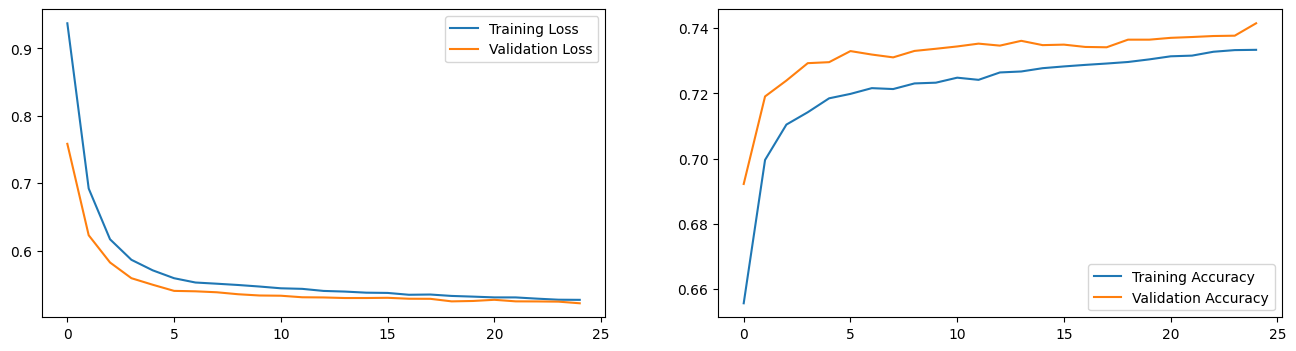

In [30]:
plot_history(history)

In [31]:
model = keras.models.load_model("nflplay_final_01.h5")
model.evaluate(test_dataset)

542/542 [==============================] - 101s 39ms/step - loss: 0.5135 - accuracy: 0.7408


[0.5135248899459839, 0.7407622933387756]

542/542 [==============================] - 22s 41ms/step


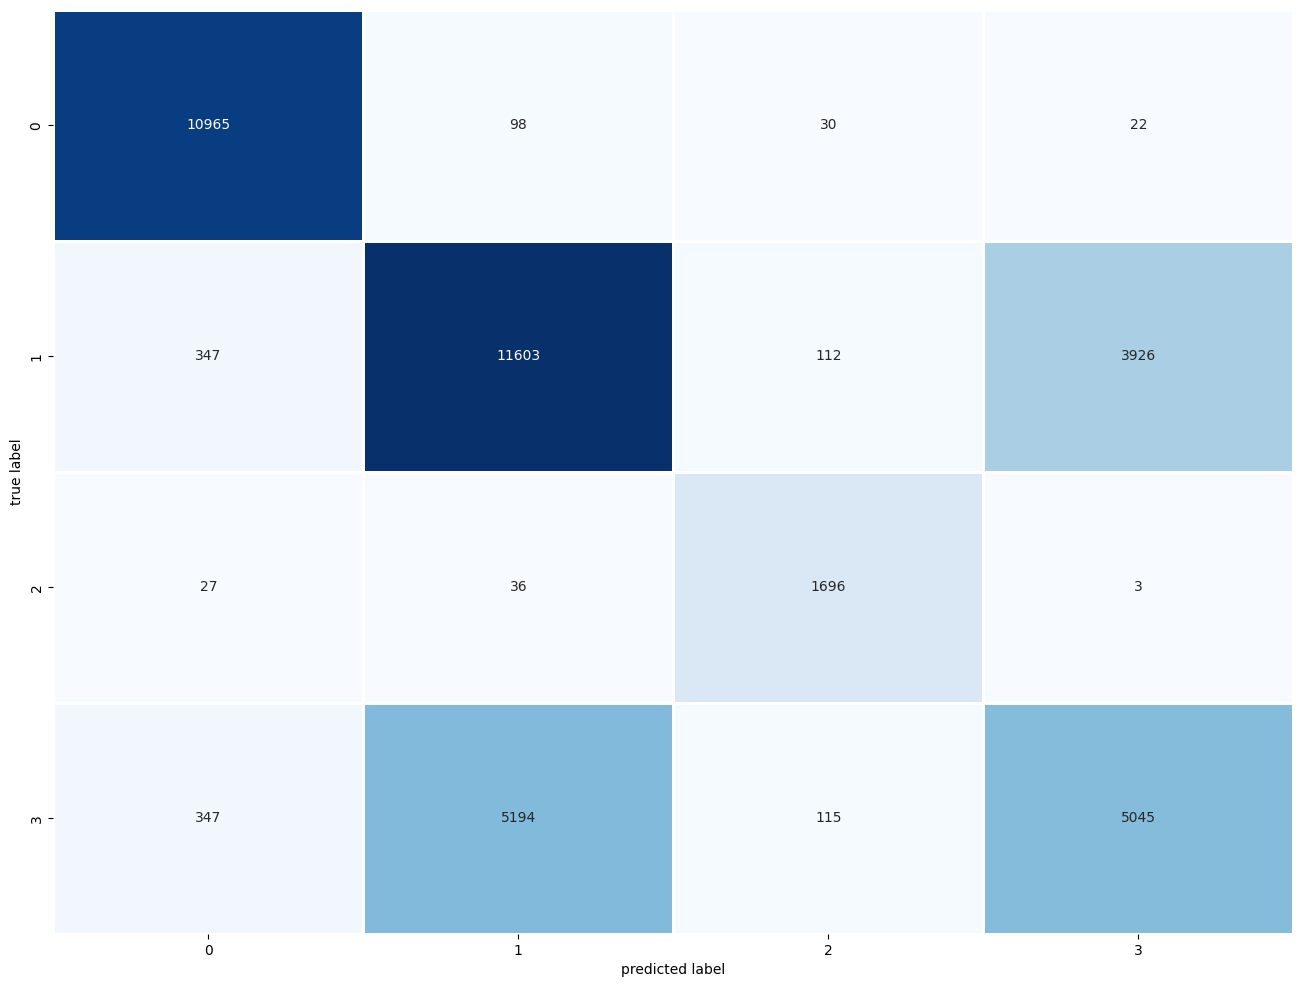

In [32]:
y_pred = model.predict(test_dataset)
y_class_pred = np.argmax(y_pred, axis=-1)
y_act = np.concatenate([y for x, y in test_dataset], axis=0)

plot_confusion_matrix(y_act, y_class_pred)

In [33]:
print_validation_report(y_act, y_class_pred)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     11115
           1       0.69      0.73      0.70     15988
           2       0.87      0.96      0.91      1762
           3       0.56      0.47      0.51     10701

    accuracy                           0.74     39566
   macro avg       0.76      0.79      0.77     39566
weighted avg       0.73      0.74      0.73     39566

Accuracy Score: 0.740762270636405
Root Mean Square Error: 1.014727520349686


### Final Model 2

In [27]:
keras.backend.clear_session()

inputs = keras.Input(shape=(sequence_length, n_feats))
x = keras.layers.Masking(mask_value=0)(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(38, recurrent_dropout = 0.2, return_sequences = False))(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 45)]          0         
                                                                 
 masking (Masking)           (None, 15, 45)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 76)               25536     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 76)                0         
                                                                 
 dense (Dense)               (None, 4)                 308       
                                                                 
Total params: 25,844
Trainable params: 25,844
Non-trainable params: 0
_________________________________________________________

In [28]:
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint("nflplay_final_02.h5", save_best_only=True),
             keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience=5),
             TimeCallback()]
history = model.fit(train_dataset, epochs = 25, validation_data = valid_dataset, callbacks = callbacks)

Epoch 1/25
786/786 [==============================] - 127s 151ms/step - loss: 0.9355 - accuracy: 0.6572 - val_loss: 0.7546 - val_accuracy: 0.6987
Epoch 2/25
786/786 [==============================] - 74s 95ms/step - loss: 0.6932 - accuracy: 0.6970 - val_loss: 0.6185 - val_accuracy: 0.7239
Epoch 3/25
786/786 [==============================] - 82s 104ms/step - loss: 0.6148 - accuracy: 0.7105 - val_loss: 0.5748 - val_accuracy: 0.7298
Epoch 4/25
786/786 [==============================] - 75s 96ms/step - loss: 0.5829 - accuracy: 0.7168 - val_loss: 0.5561 - val_accuracy: 0.7323
Epoch 5/25
786/786 [==============================] - 73s 92ms/step - loss: 0.5671 - accuracy: 0.7194 - val_loss: 0.5457 - val_accuracy: 0.7328
Epoch 6/25
786/786 [==============================] - 73s 93ms/step - loss: 0.5571 - accuracy: 0.7215 - val_loss: 0.5397 - val_accuracy: 0.7340
Epoch 7/25
786/786 [==============================] - 85s 109ms/step - loss: 0.5516 - accuracy: 0.7223 - val_loss: 0.5355 - val_accur

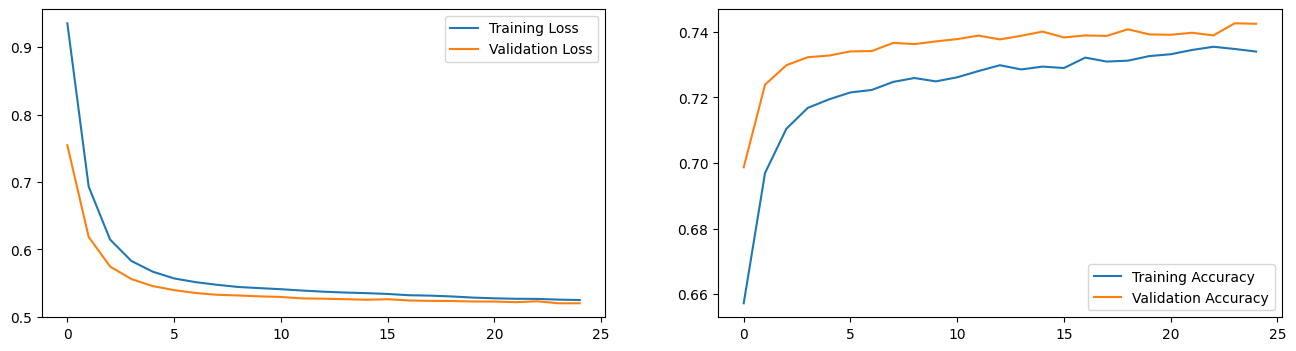

In [29]:
plot_history(history)

In [30]:
model = keras.models.load_model("nflplay_final_02.h5")
model.evaluate(test_dataset)

542/542 [==============================] - 162s 48ms/step - loss: 0.5136 - accuracy: 0.7414


[0.5136251449584961, 0.7414446473121643]

542/542 [==============================] - 26s 47ms/step


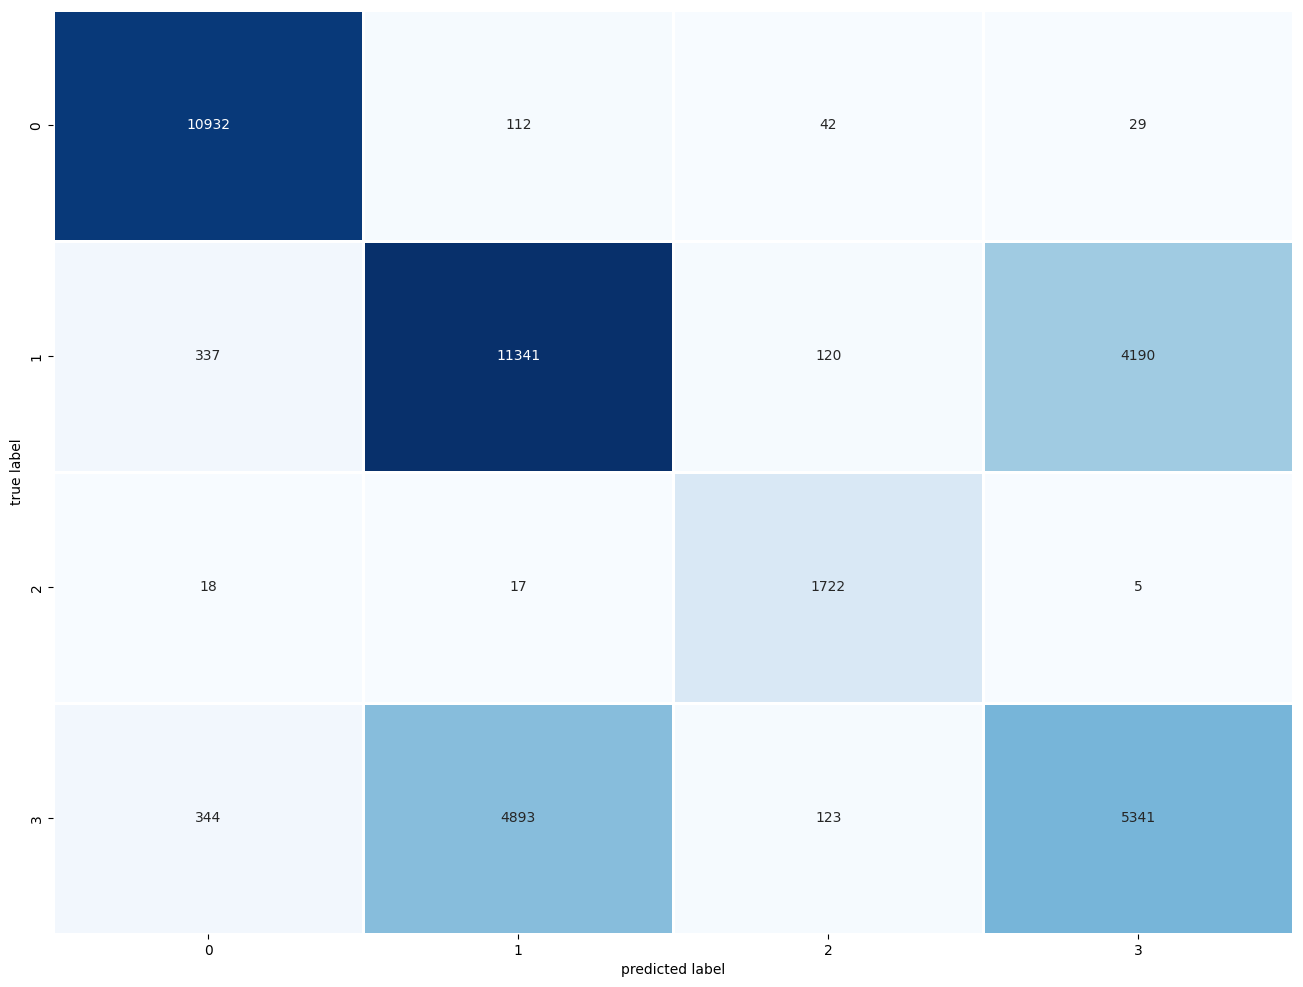

In [31]:
y_pred = model.predict(test_dataset)
y_class_pred = np.argmax(y_pred, axis=-1)
y_act = np.concatenate([y for x, y in test_dataset], axis=0)

plot_confusion_matrix(y_act, y_class_pred)

In [32]:
print_validation_report(y_act, y_class_pred)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11115
           1       0.69      0.71      0.70     15988
           2       0.86      0.98      0.91      1762
           3       0.56      0.50      0.53     10701

    accuracy                           0.74     39566
   macro avg       0.76      0.79      0.78     39566
weighted avg       0.73      0.74      0.74     39566

Accuracy Score: 0.7414446747207198
Root Mean Square Error: 1.013518791486649


### Final Model 3

In [33]:
keras.backend.clear_session()

inputs = keras.Input(shape=(sequence_length, n_feats))
x = keras.layers.Masking(mask_value=0)(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(38, recurrent_dropout = 0.2, return_sequences = True))(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Bidirectional(keras.layers.LSTM(16, recurrent_dropout = 0.2, return_sequences = False))(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 45)]          0         
                                                                 
 masking (Masking)           (None, 15, 45)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 15, 76)           25536     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 76)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               11904     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0     

In [34]:
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint("nflplay_final_03.h5", save_best_only=True),
             keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience=5),
             TimeCallback()]
history = model.fit(train_dataset, epochs = 25, validation_data = valid_dataset, callbacks = callbacks)

Epoch 1/25
786/786 [==============================] - 123s 142ms/step - loss: 0.9496 - accuracy: 0.6531 - val_loss: 0.7685 - val_accuracy: 0.6990
Epoch 2/25
786/786 [==============================] - 108s 138ms/step - loss: 0.6955 - accuracy: 0.6972 - val_loss: 0.6092 - val_accuracy: 0.7270
Epoch 3/25
786/786 [==============================] - 100s 127ms/step - loss: 0.6049 - accuracy: 0.7150 - val_loss: 0.5665 - val_accuracy: 0.7280
Epoch 4/25
786/786 [==============================] - 109s 139ms/step - loss: 0.5849 - accuracy: 0.7131 - val_loss: 0.5515 - val_accuracy: 0.7319
Epoch 5/25
786/786 [==============================] - 101s 129ms/step - loss: 0.5644 - accuracy: 0.7161 - val_loss: 0.5392 - val_accuracy: 0.7336
Epoch 6/25
786/786 [==============================] - 108s 138ms/step - loss: 0.5546 - accuracy: 0.7199 - val_loss: 0.5365 - val_accuracy: 0.7325
Epoch 7/25
786/786 [==============================] - 100s 127ms/step - loss: 0.5509 - accuracy: 0.7218 - val_loss: 0.5314 -

In [ ]:
plot_history(history)

In [ ]:
model = keras.models.load_model("nflplay_final_03.h5")
model.evaluate(test_dataset)

In [ ]:
y_pred = model.predict(test_dataset)
y_class_pred = np.argmax(y_pred, axis=-1)
y_act = np.concatenate([y for x, y in test_dataset], axis=0)

plot_confusion_matrix(y_act, y_class_pred)

In [ ]:
print_validation_report(y_act, y_class_pred)